In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib as mpl

from os.path import join
from pingouin import partial_corr
from scipy.stats import fligner, t, spearmanr, pearsonr
from nilearn import plotting, datasets, surface

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


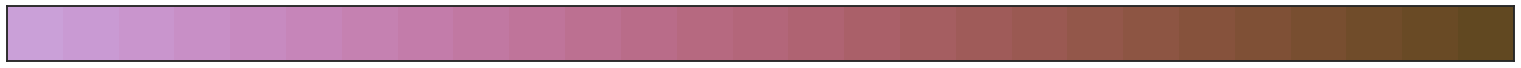

In [264]:
morph_pal = sns.cubehelix_palette(n_colors=4, start=0.6, rot=-0.6, gamma=1.0, hue=0.9, light=0.6, dark=0.3)
morph_cmap = sns.cubehelix_palette(n_colors=4, start=0.6, rot=-0.6, gamma=1.0, hue=0.9, light=0.3, dark=0.2, 
                                   as_cmap=True, reverse=True)
cell_pal = sns.cubehelix_palette(n_colors=9, start=1.7, rot=-0.8, gamma=1.0, hue=0.9, light=0.6, dark=0.3)
cell_cmap = sns.cubehelix_palette(n_colors=9, start=1.7, rot=-0.8, gamma=1.0, hue=0.9, light=0.3, dark=0.2, 
                                  as_cmap=True, reverse=True)
func_pal = sns.cubehelix_palette(n_colors=4, start=3.0, rot=-0.6, gamma=1.0, hue=0.9, light=0.6, dark=0.3)
func_cmap = sns.cubehelix_palette(n_colors=4, start=3.0, rot=-0.6, gamma=1.0, hue=0.9, light=0.3, dark=0.2, 
                                  as_cmap=True, reverse=True)

age_cmap = sns.cubehelix_palette(n_colors=27, start=0, rot=-0.8, gamma=1.0, hue=0.9, light=0.3, dark=0.2, 
                                  as_cmap=True, reverse=True)
age_pal = sns.cubehelix_palette(n_colors=27, start=5, rot=-0.8, gamma=1.0, hue=0.9, light=0.7, dark=0.3)

big_pal = morph_pal + cell_pal + func_pal
sns.palplot(age_pal)
sns.set(style="white", 
        context="talk", 
        font_scale=0.8,
        rc={"axes.facecolor": (0, 0, 0, 0),
            "font.monospace": 'Courier',
            "font.family": 'monospace'})
crayons = sns.crayon_palette(['Aquamarine', 'Jungle Green', 'Fuchsia'])

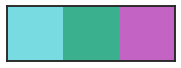

In [3]:
sns.palplot(crayons)

In [4]:
PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/"
DATA_DIR = "data/"
FIGS_DIR = "figures/"
OUTP_DIR = "output/"

In [5]:
df = pd.read_csv(join(PROJ_DIR, DATA_DIR, "data_qcd.csv"), index_col=0, header=0)

df.drop(list(df.filter(regex='lesion.*').columns), axis=1, inplace=True)
df.drop(list(df.filter(regex='.*_cf12_.*').columns), axis=1, inplace=True)
no_2yfu = df[df["interview_date.2_year_follow_up_y_arm_1"].isna() == True].index
df = df.drop(no_2yfu, axis=0)

In [6]:
deltasmri_complete = pd.concat([df.filter(regex='smri.*change_score'), 
                                df.filter(regex='mrisdp.*change_score')], axis=1).dropna()
deltarsfmri_complete = df.filter(regex='rsfmri.*change_score').dropna(how='any')
deltarsi_complete = df.filter(regex='dmri_rsi.*change_score').dropna()
deltadti_complete = df.filter(regex='dmri_dti.*change_score').dropna()

img_modalities = {'smri': deltasmri_complete,
                  'fmri': deltarsfmri_complete,
                  'rsi': deltarsi_complete, 
                  'dti': deltadti_complete}

#morph = img_modalities['smri'].filter(regex='.*vol.*').columns

# plot the distribution of variances of all structural mri measures
smri_var = img_modalities['smri'].columns
dti_var = img_modalities['dti'].columns
rsi_var = img_modalities['rsi'].columns
# separate wm and gm rsi
rsi_gm = list(img_modalities['rsi'].filter(regex='.*gm').columns) + list(img_modalities['rsi'].filter(regex='.*scs').columns)
rsi_wm = list(set(rsi_var) - set(rsi_gm))
rsi_scs = list(img_modalities['rsi'].filter(regex='.*scs').columns)
fmri_var = img_modalities['fmri'].columns
fc_cort_var = img_modalities['fmri'].filter(regex='_c_.*').columns
fc_scor_var = img_modalities['fmri'].filter(regex='_cor_.*').columns
fmri_var_var = img_modalities['fmri'].filter(regex='_var_.*').columns

#morph_var = df[df['concept'] == 'macrostructure'].index
#cell_var = df[df['concept'] == 'microstructure'].index
func_var = list(fmri_var_var) 
conn_var = list(fc_cort_var) + list(fc_scor_var)

btwn_fc = []
wthn_fc = []
for var in fc_cort_var:
    var_list = var[:-13].split('_')
    #print(var_list)
    if var_list[3] == var_list[5]:
        #print(var, 'within-network')
        wthn_fc.append(var)
    else:
        btwn_fc.append(var)
        #print(var, 'between-network')

In [7]:
imaging_apd = list(deltasmri_complete.columns) + list(deltadti_complete.columns) + list(deltarsi_complete.columns) + list(deltarsfmri_complete.columns)

In [8]:
concepts = {'morph': ['thick', 
                      'area', 
                      'vol',
                      'dtivol'],
            'cell': ['t1wcnt', 
                     'rsirni', 
                     'rsirnd',
                     'rsirnigm', 
                     'rsirndgm',
                     'dtifa', 
                     'dtimd',
                     'dtild', 
                     'dtitd'],
            'func':['var',
                    'c',
                    'cor',
                    #'subcortical-network fc'
                   ]}

In [ ]:
pd.MultiIndex.from_arrays()

In [31]:
analyses = ['Corr: Age, APC', 'Corr: Baseline, APC', 'PCorr: Age, APC', 'PCorr: Baseline, APC']
metrics = ['r', 'p(r)', 'concept', 'measure']
columns = pd.MultiIndex.from_product((analyses, metrics))
correlations = pd.DataFrame(columns=columns)
for var in imaging_apd:
    base_var = var.split('.')[0]
    temp_df = df[[var, 
                  f'{base_var}.baseline_year_1_arm_1', 
                  'interview_age.baseline_year_1_arm_1']].dropna()
    # correlation between start and change
    r, p = spearmanr(temp_df[var], temp_df[f'{base_var}.baseline_year_1_arm_1'])
    correlations.at[base_var, 
                    ('Corr: Baseline, APC', 'r')] = r
    correlations.at[base_var, 
                    ('Corr: Baseline, APC', 'p(r)')] = p
    # correlation between baseline age and change
    r, p = spearmanr(temp_df[var], temp_df['interview_age.baseline_year_1_arm_1'])
    correlations.at[base_var, 
                  ('Corr: Age, APC', 'r')] = r
    correlations.at[base_var, 
                  ('Corr: Age, APC', 'p(r)')] = p
    # partial correlation between start and change, controlling for age
    pcorr_df = partial_corr(temp_df, 
                        var,  
                        f'{base_var}.baseline_year_1_arm_1',
                        'interview_age.baseline_year_1_arm_1',)
    correlations.at[base_var, 
                  ('PCorr: Baseline, APC', 'r')] = pcorr_df.iloc[0]['r']
    correlations.at[base_var, 
                  ('PCorr: Baseline, APC', 'p(r)')] = pcorr_df.iloc[0]['p-val']
    # partial correlation between age and change, controlling for start
    pcorr_df = partial_corr(temp_df, 
                        var, 
                        'interview_age.baseline_year_1_arm_1', 
                        f'{base_var}.baseline_year_1_arm_1')
    correlations.at[base_var, 
                  ('PCorr: Age, APC', 'r')] = pcorr_df.iloc[0]['r']
    correlations.at[base_var, 
                  ('PCorr: Age, APC', 'p(r)')] = pcorr_df.iloc[0]['p-val']
    if 'mrisdp' in var:
        pass
    elif '_' in var:
        var_list = base_var.split('_')
        correlations.at[base_var, 
                        ('Corr: Age, APC', 'measure')] = var_list[1]
        if var_list[1] in concepts['morph']:
            correlations.at[base_var, 
                            ('Corr: Age, APC', 'concept')] = 'macrostructure'
        elif var_list[1] in concepts['cell']:
            correlations.at[base_var, 
                            ('Corr: Age, APC', 'concept')] = 'microstructure'
        if var_list[1] in concepts['func']:
            correlations.at[base_var, 
                            ('Corr: Age, APC', 'concept')] = 'function'
        if var in btwn_fc:
            correlations.at[base_var, 
                            ('Corr: Age, APC', 'measure')] = 'between-network fc'
        elif var in wthn_fc:
            correlations.at[base_var, 
                            ('Corr: Age, APC', 'measure')] = 'within-network fc'
        elif var in fc_scor_var:
            correlations.at[base_var, 
                            ('Corr: Age, APC', 'measure')] = 'subcortical-network fc'
        elif var in rsi_scs:
            if 'rsirni' in var:
                correlations.at[base_var, 
                                ('Corr: Age, APC', 'measure')] = 'rsirnigm'
            elif 'rsirnd' in var:
                correlations.at[base_var, 
                                ('Corr: Age, APC', 'measure')] = 'rsirndgm'
correlations.dropna(how='all', axis=1, inplace=True)

In [32]:
long_names = {'var': 'BOLD',
              'between-network fc': 'FC (btwn)',
              'within-network fc': 'FC (wthn)',
              'subcortical-network fc': 'FC (sc)',
              'dtivol': 'WMV',
              'vol': 'GMV',
              'thick': 'CT',
              'area': 'CA',
              'dtifa': 'FA',
              'dtimd': 'MD',
              'dtild': 'LD',
              'dtitd': 'TD',
              'rsirni': 'RNI',
              'rsirnd': 'RND',
              'rsirnigm': 'RNI (gm)',
              'rsirndgm': 'RND (gm)',
              't1wcnt': 'G/W'}

In [33]:
correlations.replace(long_names, inplace=True)
correlations.columns = correlations.columns.to_flat_index()

In [314]:
len(correlations.index)

2398

In [315]:
len(correlations[correlations[('PCorr: Baseline, APC', 'p(r)')] <= 0.01].index)

2398

In [74]:
correlations.rename({('Corr: Age, APC', 'measure'): 'measure',
                     ('Corr: Age, APC', 'concept'): 'concept',
                     ('PCorr: Baseline, APC', 'r'): 'Partial correlation: baseline, APΔ',
                     ('PCorr: Age, APC', 'r'): 'Partial correlation: age, APΔ'}, axis=1, inplace=True)

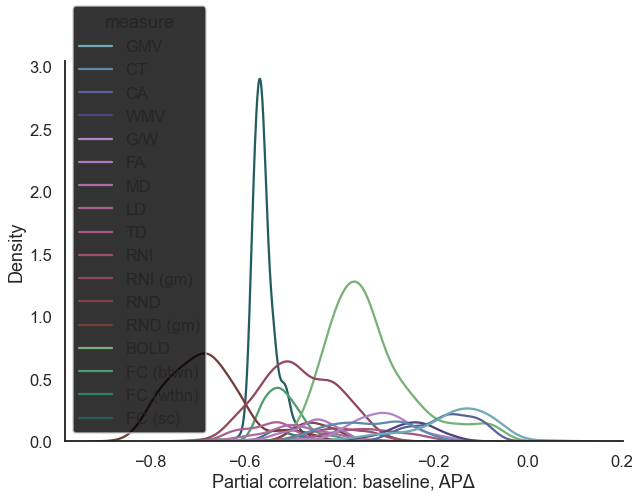

In [75]:
# first, let's plot the correlations, color-coded by concept & measure
fig,ax = plt.subplots(figsize=(10,7))
g = sns.kdeplot('Partial correlation: baseline, APΔ', hue='measure', 
                hue_order=['GMV', 'CT', 'CA', 'WMV',
                           'G/W', 'FA', 'MD', 'LD', 'TD', 
                           'RNI', 'RNI (gm)','RND','RND (gm)',
                           'BOLD', 'FC (btwn)', 'FC (wthn)', 'FC (sc)'], 
                data=correlations[correlations[('PCorr: Baseline, APC', 'p(r)')] <= 0.01], 
                palette=big_pal)
sns.despine()

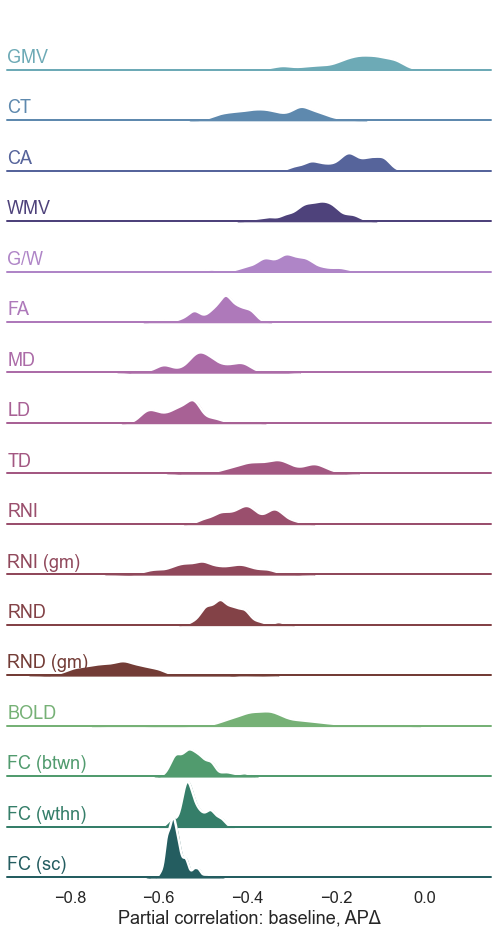

In [76]:
g = sns.FacetGrid(correlations, 
                  row="measure", row_order=['GMV', 'CT', 'CA', 'WMV',
                           'G/W', 'FA', 'MD', 'LD', 'TD', 
                           'RNI', 'RNI (gm)','RND','RND (gm)',
                           'BOLD', 'FC (btwn)', 'FC (wthn)', 'FC (sc)'],
                  hue="measure", hue_order=['GMV', 'CT', 'CA', 'WMV',
                           'G/W', 'FA', 'MD', 'LD', 'TD', 
                           'RNI', 'RNI (gm)','RND','RND (gm)',
                           'BOLD', 'FC (btwn)', 'FC (wthn)', 'FC (sc)'],
                  aspect=10, 
                  height=.8, palette=big_pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, 'Partial correlation: baseline, APΔ',
      bw_adjust=.55, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, 'Partial correlation: baseline, APΔ', clip_on=False, color="w", lw=2.5, bw_adjust=.55)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, #fontweight="bold", 
            color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, 'Partial correlation: baseline, APΔ')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.2)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.savefig(f'../{FIGS_DIR}/start_change_minus_age_pcorr.png', dpi=400)

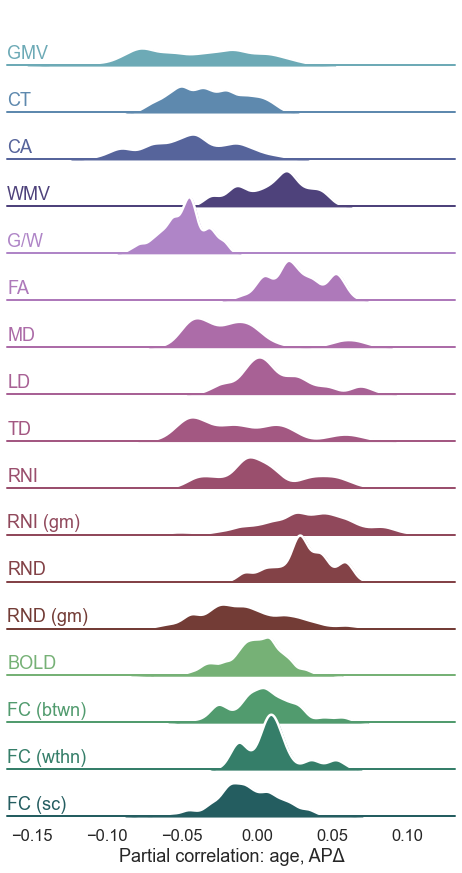

In [77]:
sns.set_theme(context='talk', style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
g = sns.FacetGrid(correlations, 
                  row="measure", row_order=['GMV', 'CT', 'CA', 'WMV',
                           'G/W', 'FA', 'MD', 'LD', 'TD', 
                           'RNI', 'RNI (gm)','RND','RND (gm)',
                           'BOLD', 'FC (btwn)', 'FC (wthn)', 'FC (sc)'],
                  hue="measure", hue_order=['GMV', 'CT', 'CA', 'WMV',
                           'G/W', 'FA', 'MD', 'LD', 'TD', 
                           'RNI', 'RNI (gm)','RND','RND (gm)',
                           'BOLD', 'FC (btwn)', 'FC (wthn)', 'FC (sc)'],
                  aspect=10, 
                  height=.75, palette=big_pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, 'Partial correlation: age, APΔ',
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, 'Partial correlation: age, APΔ', clip_on=False, color="w", lw=2.5, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, #fontweight="bold", 
            color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, 'Partial correlation: age, APΔ')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.2)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.savefig(f'../{FIGS_DIR}/age_change_minus_start_pcorr.png', dpi=400)

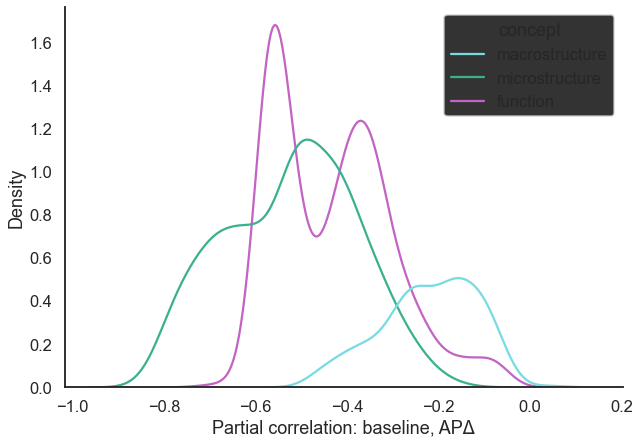

In [80]:
fig,ax = plt.subplots(figsize=(10,7))
g = sns.kdeplot('Partial correlation: baseline, APΔ', hue='concept', 
                hue_order=['macrostructure', 'microstructure', 'function'], 
                data=correlations, palette=crayons, )
sns.despine()

In [329]:
# scrap for now, was intended to build region-wise scatterplots of start/change
# but I think that's too many data points...
measure = 'GMV'
variables = correlations[correlations['measure'] == measure].index
starts_cort = [f'{i}.baseline_year_1_arm_1' for i in variables if 'scs' not in i]
changes_cort = [f'{i}.change_score' for i in variables if 'scs' not in i]
starts_subc = [f'{i}.baseline_year_1_arm_1' for i in variables if 'cdk' not in i]
changes_subc = [f'{i}.change_score' for i in variables if 'cdk' not in i]

In [325]:
start = df[starts_cort[1]]#.mean(axis=1)
change = df[changes_cort[1]]
age = df['interview_age.baseline_year_1_arm_1']#.mean(axis=1)

In [332]:
changes_cort[1].split('.')[0]

'smri_vol_cdk_banksstslh'

In [333]:
start_change = pd.concat([start, change, age], axis=1)
start_change.columns = ['baseline', 'APC', 'age']

Text(0.5, 1.0, 'smri_vol_cdk_banksstslh')

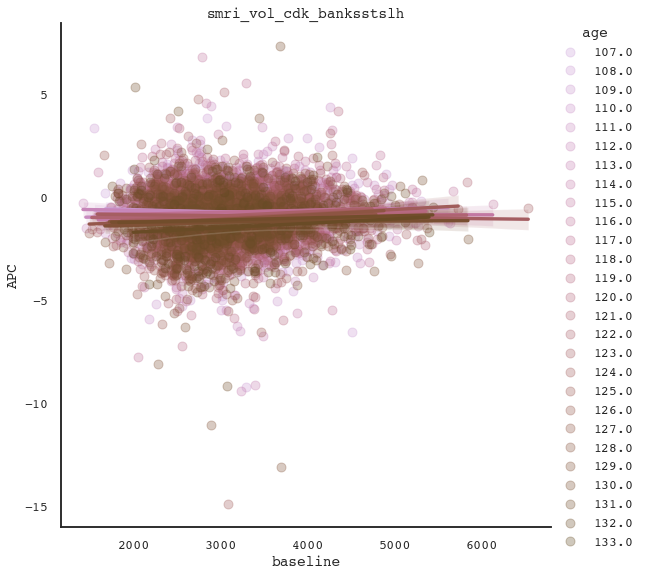

In [335]:
g = sns.lmplot(x='baseline', y='APC', data=start_change, palette=age_pal,
                 hue='age', scatter_kws={'alpha': 0.3}, height=8, y_jitter=True)
g.ax.set_title(starts[1].split('.')[0])

In [387]:
region_start_change = starts_cort[1:] + changes_cort[1:]
subcort_start_change = starts_subc[1:] + changes_subc[1:]

In [388]:
wide_boi = df[region_start_change]
wide_boi_scs = df[subcort_start_change]

In [389]:
wide_boi['index'] = wide_boi.index
wide_boi_scs['index'] = wide_boi_scs.index

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_5550/4135441165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wide_boi['index'] = wide_boi.index
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_5550/4135441165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wide_boi_scs['index'] = wide_boi_scs.index


In [390]:
long_boi = wide_boi.melt(value_vars=list(starts_cort[1:] + changes_cort[1:]), value_name='value', 
                         id_vars='index', var_name='region')

long_boi_scs = wide_boi_scs.melt(value_vars=list(starts_subc[1:] + changes_subc[1:]), value_name='value', 
                         id_vars='index', var_name='region')

In [391]:
for i in long_boi.index:
    splitskies = long_boi.loc[i]['region'].split('.')
    region = splitskies[0].split('_')[-1]
    long_boi.at[i, 'timepoint'] = splitskies[1]
    long_boi.at[i, 'region'] = region

In [392]:
for i in long_boi_scs.index:
    splitskies = long_boi_scs.loc[i]['region'].split('.')
    region = splitskies[0].split('_')[-1]
    long_boi_scs.at[i, 'timepoint'] = splitskies[1]
    long_boi_scs.at[i, 'region'] = region

In [393]:
change = long_boi[long_boi['timepoint'] == 'change_score']
base = long_boi[long_boi['timepoint'] == 'baseline_year_1_arm_1']
change_scs = long_boi_scs[long_boi_scs['timepoint'] == 'change_score']
base_scs = long_boi_scs[long_boi_scs['timepoint'] == 'baseline_year_1_arm_1']

In [394]:
change = change.rename({'value': 'change'}, axis=1).drop('timepoint', axis=1)
base = base.rename({'value': 'baseline'}, axis=1).drop('timepoint', axis=1)

change_scs = change_scs.rename({'value': 'change'}, axis=1).drop('timepoint', axis=1)
base_scs = base_scs.rename({'value': 'baseline'}, axis=1).drop('timepoint', axis=1)

In [395]:
base['change'] = change['change'].values
base_scs['change'] = change_scs['change'].values

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


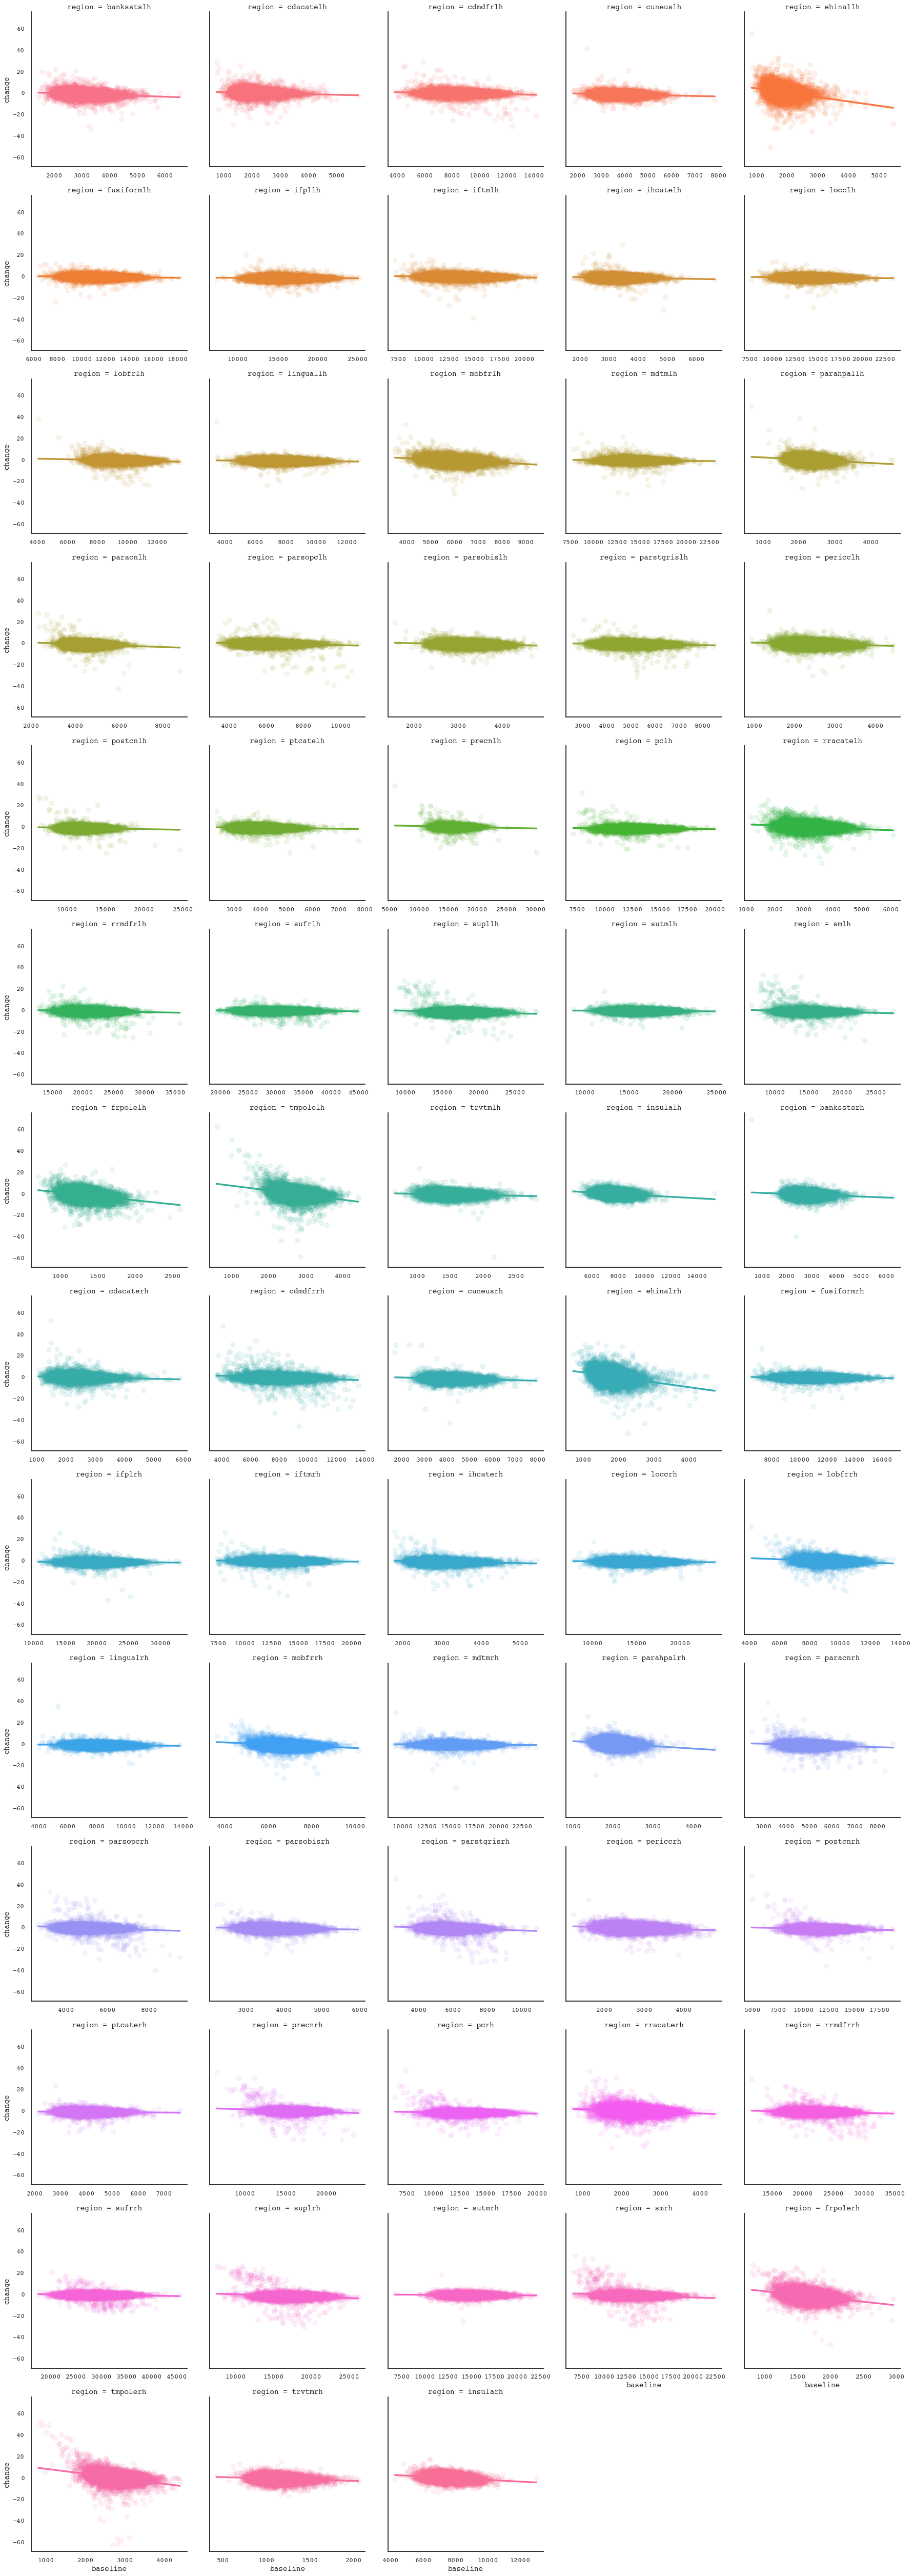

In [396]:
# need to sepatate cortical and subcortical
sns.lmplot(x='baseline', y='change', data=base, 
           col='region', col_wrap=5, hue='region', 
           legend=False, scatter_kws={'alpha': 0.1}, 
           sharex=False)

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


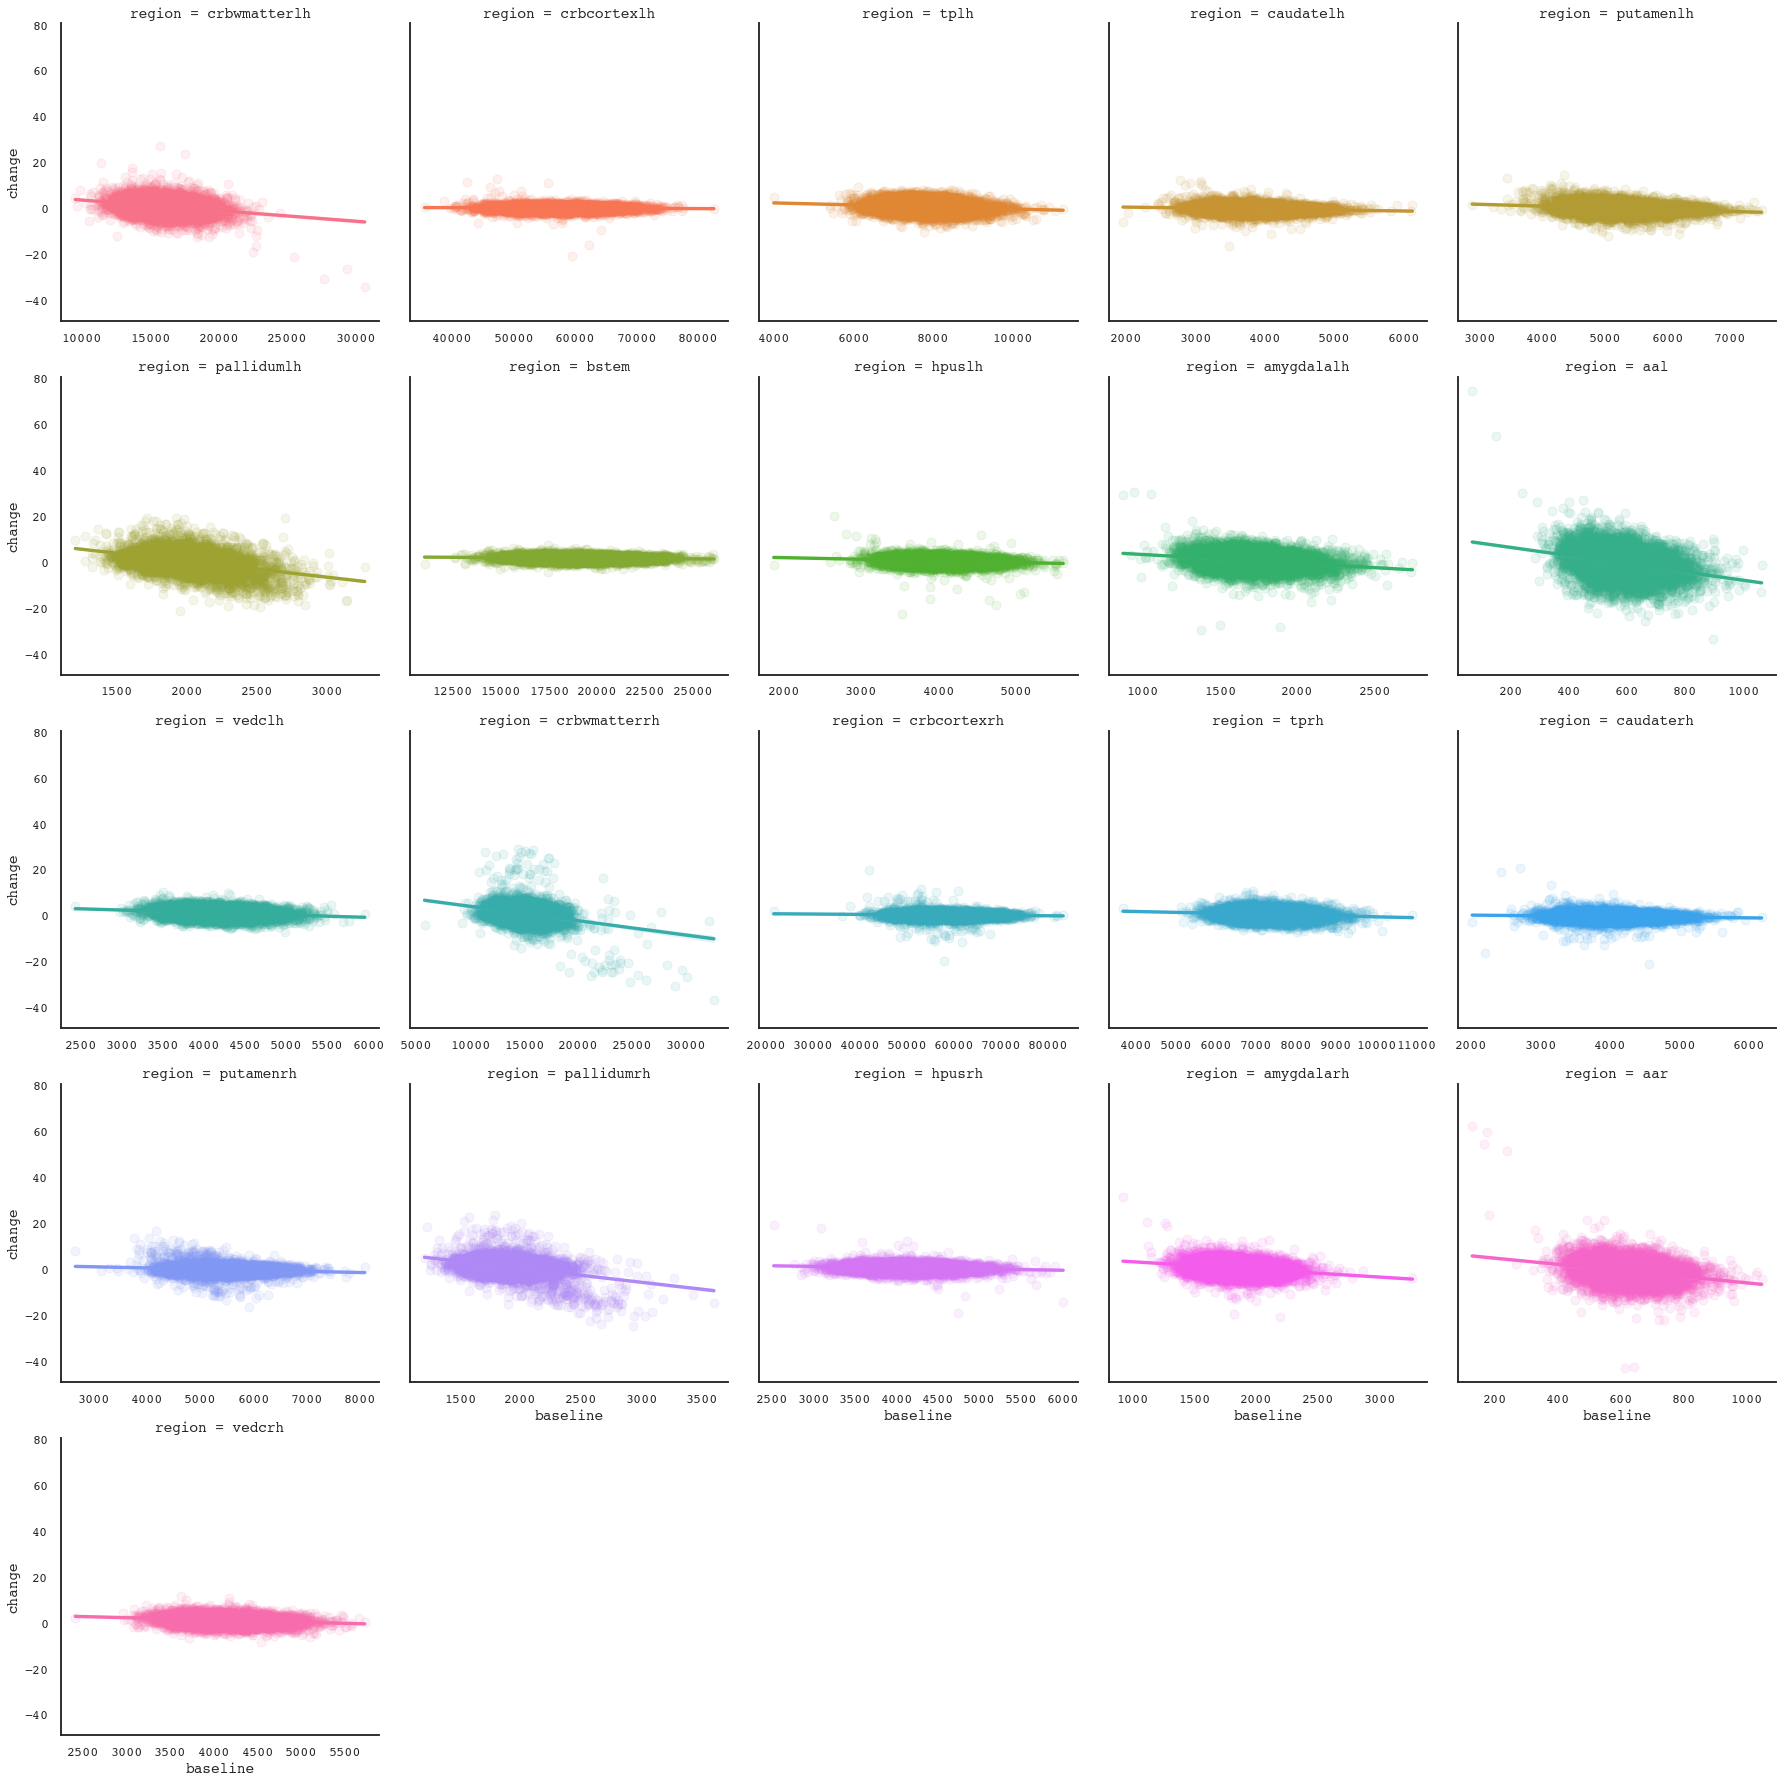

In [397]:
# need to sepatate cortical and subcortical
sns.lmplot(x='baseline', y='change', data=base_scs, 
           col='region', col_wrap=5, hue='region', 
           legend=False, scatter_kws={'alpha': 0.1}, 
           sharex=False)